In [19]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from scipy import stats

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Get sessions

In [3]:
COLORS = get_colors()

source = '/home/andrey/storage2/andrey/data/processed'
assets = '/home/andrey/storage2/andrey/data/projects/24_shift/assets'
reports_folder = '/home/andrey/storage2/andrey/data/projects/24_shift/reporting'

animals = ['003281', '003282', '003908', '003909', '005363', '005364']
#animals = ['003281', '003282']

s_list_single = get_sessions_list(source, animals, 'SHIFT single +dark')
len(s_list_single)

21

In [4]:
# Just single sessions - LIGHT vs DARK
shift_A_B_single = get_fields_between_epochs(source, s_list_single, 'A', 'B')
shift_A_Ad_single = get_fields_between_epochs(source, s_list_single, 'A', 'Ad')
shift_B_Bd_single = get_fields_between_epochs(source, s_list_single, 'B', 'Bd')
shift_A_Bd_single = get_fields_between_epochs(source, s_list_single, 'A', 'Bd')
shift_B_Ad_single = get_fields_between_epochs(source, s_list_single, 'B', 'Ad')
shift_Ad_Bd_single = get_fields_between_epochs(source, s_list_single, 'Ad', 'Bd')

No required H5 files found for 2020-10-13_10-21-47
No required H5 files found for 2020-10-23_12-57-03
PF match found for 333 fields from total 575 A and 578 B fields
No required H5 files found for 2020-10-13_10-21-47
No required H5 files found for 2020-10-23_12-57-03
PF match found for 298 fields from total 575 A and 600 Ad fields
No required H5 files found for 2020-10-13_10-21-47
No required H5 files found for 2020-10-23_12-57-03
PF match found for 302 fields from total 567 B and 542 Bd fields
No required H5 files found for 2020-10-13_10-21-47
No required H5 files found for 2020-10-23_12-57-03
PF match found for 210 fields from total 447 A and 436 Bd fields
No required H5 files found for 2020-10-13_10-21-47
No required H5 files found for 2020-10-23_12-57-03
PF match found for 250 fields from total 461 B and 483 Ad fields
No required H5 files found for 2020-10-13_10-21-47
No required H5 files found for 2020-10-23_12-57-03
PF match found for 319 fields from total 590 Ad and 542 Bd field

In [5]:
print(list(shift_A_B_single))

['animal', 'session', 'electrode', 'unit', 'field_A', 'field_B', 'overlap_norm', 'sic_A', 'sic_B', 'isol_dist', 'peak_FR_A', 'peak_FR_B', 'COMa_x', 'COMa_y', 'COMb_x', 'COMb_y', 'shift', 'size_A', 'size_B']


# Filters

## Bad fields

- information content > 0.2
- peak firing rate > 1.5Hz
- isolation distance > 15

In [6]:
def get_idxs_by_quality(dataset):
    sic, pfr, iso = 0.2, 1.5, 15    # sic > 0.2, peak firing rate > 1.5 Hz, isolation distance > 15
    idxs_sic = (dataset['sic_A'] > sic) & (dataset['sic_B'] > sic)
    idxs_pfr = (dataset['peak_FR_A'] > pfr) & (dataset['peak_FR_B'] > pfr)
    idxs_iso = (dataset['isol_dist'] > iso)
    return idxs_sic & idxs_pfr & idxs_iso

## Split in groups by shift range

In [7]:
def get_idxs_by_shift_range(dataset, shift_min, shift_max):
    return (dataset['shift'] > shift_min) & (dataset['shift'] < shift_max)

# ANALYSIS

## Examples of cells

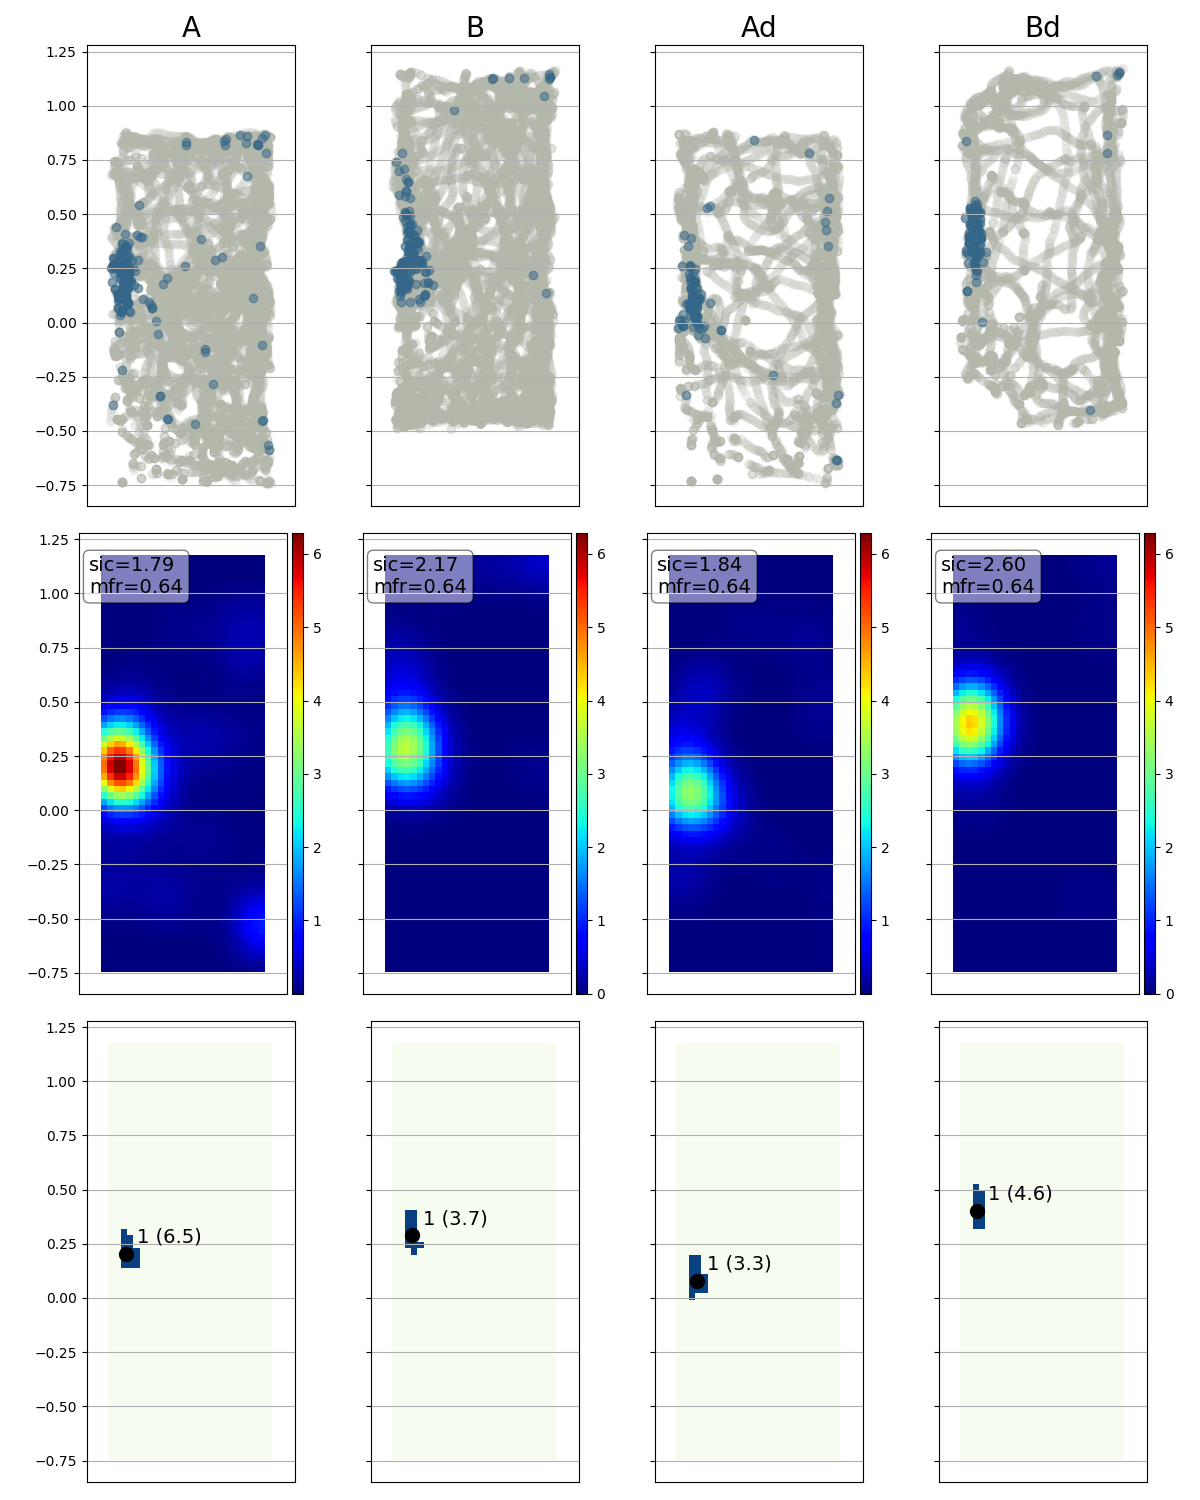

In [28]:
from IPython.display import Image

example_animal = '005363'
example_session = '2020-10-26_13-30-00'
example_unit = '2_7'
# 005363_2020-10-16_13-45-47_3_16 - grid like pattern
# 005363_2020-10-26_13-30-00_2_7  - multisensory (also 005363_2020-10-16_13-45-47_3_3)
# 005363_2020-10-18_14-39-16_4_6  - boundary driven
# 005363_2020-10-16_13-45-47_4_2  - visually driven


example = os.path.join(source, example_animal, example_session, 'analysis', 'bootstrapped', \
                       '%s_%s_%s.png' % (example_animal, example_session, example_unit))
Image(filename = example, width=600)

## 3 peaks in shift histogram

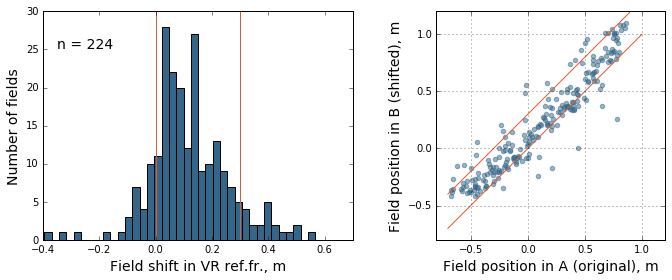

In [11]:
idxs = get_idxs_by_quality(shift_A_B_single)
data = np.array(shift_A_B_single[idxs]['shift'])
pos_A = np.array(shift_A_B_single[idxs]['COMa_y'])
pos_B = np.array(shift_A_B_single[idxs]['COMb_y'])
bins = 42

fig = figure(figsize=(10, 4))

# histogram of COM shifts
ax = fig.add_subplot(121)
ax.set_xlim(-0.4, 0.7)
ax.hist(data, bins, color=COLORS['a'])
ax.axvline(0, color=COLORS['b'])
ax.axvline(0.3, color=COLORS['b'])
ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
ax.set_ylabel('Number of fields', fontsize=14)
ax.text(-0.35, 0.9 * np.histogram(data, bins)[0].max(), 'n = %d' % len(data), fontsize=14)


ax = fig.add_subplot(122)
ax.set_xlim(-.8, 1.2)
ax.set_ylim(-.8, 1.2)
ax.set_aspect('equal')
ax.grid()
ax.scatter(pos_A, pos_B, alpha=0.5, color=COLORS['a'])
line = np.linspace(-0.7, 1.0, 10)
ax.plot(line, line, color=COLORS['b'], label='no change line')
ax.plot(line, line + 0.3, color=COLORS['b'], label='no change line')
ax.set_xlabel('Field position in A (original), m', fontsize=14)
ax.set_ylabel('Field position in B (shifted), m', fontsize=14)

fig.tight_layout()
#filename = "shift_histogram_all_physical_BOOTSTRAP.png"
#fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## More VR fields in the middle?

results:
- this also explains bias of the 0.3 group to the left. Fields near the borders can't have firing outside arena so that leads to the skewness to the left
- result 2: animals tend to use visual reference frame in the absence of other inputs. Tactile (border) information dominates the visual input near boundaries

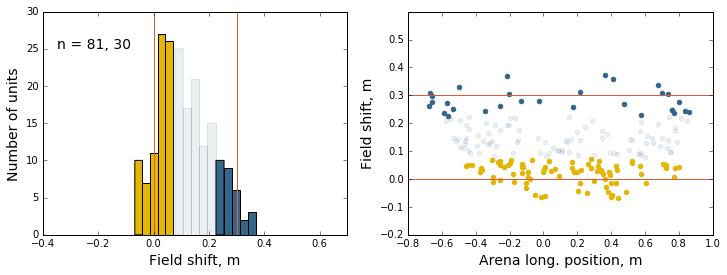

In [13]:
idxs = get_idxs_by_quality(shift_A_B_single)

delta = 0.075

idxs_0_ = (idxs & get_idxs_by_shift_range(shift_A_B_single, 0 - delta, 0 + delta))
idxs_15_ = (idxs & get_idxs_by_shift_range(shift_A_B_single, 0.15 - delta, 0.15 + delta))
idxs_30_ = (idxs & get_idxs_by_shift_range(shift_A_B_single, 0.3 - delta, 0.3 + delta))
#idxs_15_ = (idxs & get_idxs_by_shift_range(shift_A_B, 0.1, 0.2))
#idxs_out_ =  np.setdiff1d(idxs_filt, np.concatenate([idxs_0_30_, idxs_15_]))

total = len(idxs_0_) + len(idxs_15_) + len(idxs_30_)


fig = figure(figsize=(12, 4))

# --------- histogram of COM shifts ----------

ax = fig.add_subplot(121)
ax.set_xlim(-0.4, 0.7)
ax.hist(shift_A_B_single[idxs_0_]['shift'], 5, color=COLORS['d'])
ax.hist(shift_A_B_single[idxs_30_]['shift'], 5, color=COLORS['a'])
ax.hist(shift_A_B_single[idxs_15_]['shift'], 5, color=COLORS['a'], alpha = 0.1)
#ax.hist(data_s[idxs_out_][:, 6], 50, color=color_a, alpha = 0.1)
#ax.hist(data_s[idxs_filt][:, 6], 50, color=color_a, alpha=0.1)  # like this they don't match

ax.axvline(0, color=COLORS['b'])
ax.axvline(0.3, color=COLORS['b'])
ax.set_xlabel('Field shift, m', fontsize=14)
ax.set_ylabel('Number of units', fontsize=14)
ax.text(-0.35, 25, 'n = %d, %d' % (idxs_0_.sum(), idxs_30_.sum()), fontsize=14)

# --------- COM shift distribution along the arena -------

ax = fig.add_subplot(122)
ax.set_ylim(-0.2, 0.6)
ax.set_xlabel('Arena long. position, m', fontsize=14)
ax.set_ylabel('Field shift, m', fontsize=14)
ax.scatter(shift_A_B_single[idxs_0_]['COMa_y'], shift_A_B_single[idxs_0_]['shift'], color=COLORS['d'])
ax.scatter(shift_A_B_single[idxs_30_]['COMa_y'], shift_A_B_single[idxs_30_]['shift'], color=COLORS['a'])
ax.scatter(shift_A_B_single[idxs_15_]['COMa_y'], shift_A_B_single[idxs_15_]['shift'], color=COLORS['a'], alpha = 0.1)
#ax.scatter(data_s[idxs_out_][:, 15], data_s[idxs_out_][:, 6], color=color_a, alpha = 0.1)
ax.axhline(0.3, color=COLORS['b'])
ax.axhline(0.0, color=COLORS['b'])


# b_x = np.array(data_s[idxs_0_30_][:, 15], dtype=float)
# b_y = np.array(data_s[idxs_0_30_][:, 6], dtype=float)
# a, b, c = np.polyfit(b_x, b_y, 2)

# y_min = data_s[idxs_filt][:, 15].min()
# y_max = data_s[idxs_filt][:, 15].max()

# x_space = np.linspace(y_min, y_max, 11)
# y_space = [(a * (x**2) + b * x + c) for x in x_space]

# ax.plot(x_space, y_space, linewidth=2, ls='--', color=color_b)

#filename = "field_arena_distribution_physical.png"
#fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Population: dynamics LIGHT vs DARK

In [23]:
def plot_hist(ax, data, bins, plot_median=True):
    ax.set_xlim(-0.4, 0.7)
    ax.hist(data, bins, color=COLORS['a'])
    ax.axvline(0, color=COLORS['b'])
    ax.axvline(0.3, color=COLORS['b'])

    if not plot_median:
        return
    
    tt_stat_CD, tt_pval_CD = stats.ttest_1samp(data, 0.0)
    hist_max = np.histogram(data, bins)[0].max()

    ax.axvline(np.median(data), ls='--', color=COLORS['b'])
    ax.text(x_lim_l + 0.05, 0.9 * np.histogram(data, bins)[0].max(), 'n = %d' % len(data), fontsize=14)
    ax.text(x_lim_l + 0.05, 0.8 * np.histogram(data, bins)[0].max(), 'med = %.2f' % np.median(data), fontsize=14)
    ax.text(x_lim_l + 0.05, 0.7 * hist_max, 'p-val = %.3f' % tt_pval_CD, fontsize=14)

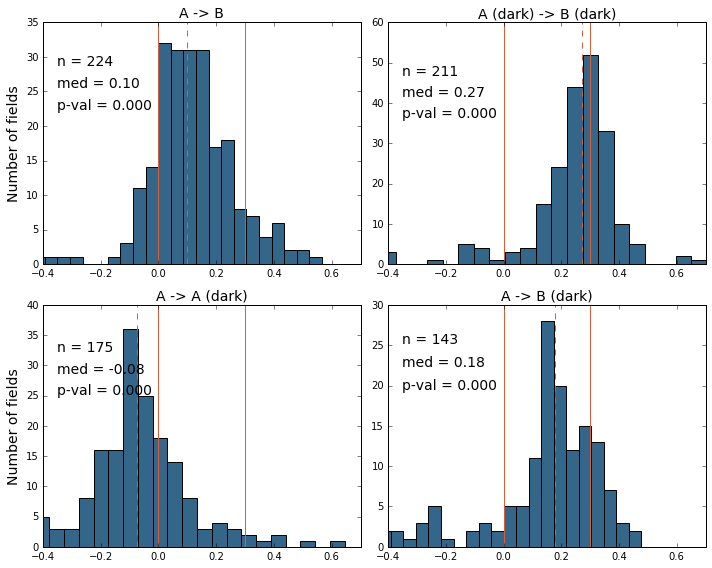

In [34]:
gspec = gridspec.GridSpec(ncols=2, nrows=2)
fig = figure(figsize=(10, 8))
x_lim_l = -0.4
x_lim_r =  0.7

# A - B in light (should be 0.15), Ad - Bd in dark (should be 0.3)
ax = fig.add_subplot(gspec[0, 0])
ax.set_ylabel('Number of fields', fontsize=14)
ax.set_title("A -> B", fontsize=14)
plot_hist(ax, np.array(shift_A_B_single[get_idxs_by_quality(shift_A_B_single)]['shift']), 25)
ax = fig.add_subplot(gspec[0, 1])
ax.set_title("A (dark) -> B (dark)", fontsize=14)
plot_hist(ax, np.array(shift_Ad_Bd_single[get_idxs_by_quality(shift_Ad_Bd_single)]['shift']), 25)


# A - Ad light/dark (should be 0?), B - Bd light/dark (should be 0.15?)
ax = fig.add_subplot(gspec[1, 0])
ax.set_ylabel('Number of fields', fontsize=14)
ax.set_title("A -> A (dark)", fontsize=14)
plot_hist(ax, np.array(shift_A_Ad_single[get_idxs_by_quality(shift_A_Ad_single)]['shift']), 25)
ax = fig.add_subplot(gspec[1, 1])
ax.set_title("A -> B (dark)", fontsize=14)
plot_hist(ax, np.array(shift_A_Bd_single[get_idxs_by_quality(shift_A_Bd_single)]['shift']), 25)


fig.tight_layout()
filename = "vSHIFT_shifts_in_diff_conditions_single.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Proportion of fields that keep their fields in dark

In [14]:
# match stats
match_both = []
match_A_Ad = []
match_B_Bd = []
match_none = []

def get_match_idxs(dataset, row):
    idxs_1 = (dataset['session'] == row['session'])
    idxs_2 = (dataset['electrode'] == row['electrode'])
    idxs_3 = (dataset['unit'] == row['unit'])
    idxs_4 = (dataset['field_A'] == row['field_A'])
    return idxs_1 & idxs_2 & idxs_3 & idxs_4

for i, row in shift_A_B_single[get_idxs_by_quality(shift_A_B_single)].iterrows():
    
    # for each matched pair in light (A, B) search for pair in dark (A, Ad and B, Bd)
    idxs_A = get_match_idxs(shift_A_Ad_single, row)
    idxs_B = get_match_idxs(shift_B_Bd_single, row)
    
    if idxs_A.any() and idxs_B.any():
        match_both.append(i)
    elif idxs_A.any():
        match_A_Ad.append(i)
    elif idxs_B.any():
        match_B_Bd.append(i)
    else:
        match_none.append(i)

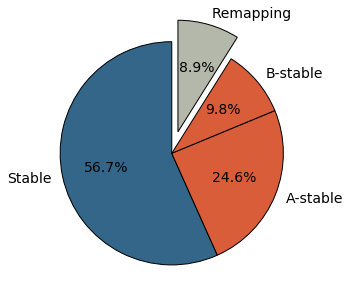

In [15]:
data = [len(match_both), len(match_A_Ad), len(match_B_Bd), len(match_none)]
labels = 'Stable', 'A-stable', 'B-stable', 'Remapping'
colors = [COLORS['a'], COLORS['b'], COLORS['b'], COLORS['f']]
explode = (0, 0, 0, 0.2)

fig = figure(figsize=(5, 5))
ax = fig.add_subplot(111)

wedges, labels, autopct = ax.pie(data, explode=explode, colors=colors, labels=labels, \
             autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
for lab in labels:
    lab.set_fontsize(14)
    
#filename = "vSHIFT_both_population_stability_in_dark.png"
#fig.savefig(os.path.join(os.path.join(reports_folder), filename))